# Implications of filtering ice clouds

We want to isolate the radiative effects of low clouds. Although this type of clouds is the predominant one in our domain that is situated in the North Atlantic Trades, we do occasionally have high clouds in the domain. These high clouds become more frequent with the warming signal applied to the boundary conditions.

To isolate the low clouds we filtered the data, using column integrated ice content. Any data point (cell) with an ice content that exceed a threshold ($10^{-5}$) is excluded from the analysis. But the number of points that exceed this threshold is not fixed, nor are their positions. This means we are masking a random portion of our domain. For any variable that is not spatially homogenious, the mean over the domain with and without the masking will not be the same. Of course this is also true for variables that are not affected by ice clouds. A good example of the unwanted effects of *ice cloud filtering* is how it affects the domain averaged incoming solar radiation (see below). Our domain is big enough to have a significant gradient in insulation as the sun is rising or setting.

This effect adds noise to our signal. It is weaker for variables that are less heteorogeneous on a large scale. The albedo seems to be less affected.

In [52]:
# avoid dask warnings in the output
import dask
dask.config.set(**{'array.slicing.split_large_chunks': True})

import sys 
import os
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)

import file_handling as fh
import xarray as xr
import postprocessing as pp
import pandas as pd

fh.disable_warnings()

def shift_time(dataset: xr.Dataset, offset: int = 0, time_var: str = 'time') -> xr.Dataset:
    """
    Shift the time variable in an xarray.Dataset from UTC to local time using a specified UTC offset.

    Parameters:
    - dataset (xarray.Dataset): The dataset containing the time variable to be shifted.
    - offset (int, optional): The time difference from UTC in hours. Default is 0.
    - time_var (str, optional): The name of the time variable within the dataset. Default is 'time'.

    Returns:
    - xarray.Dataset: A new dataset with the time variable shifted by the specified UTC offset.
    """
    if time_var not in dataset: raise ValueError(f"The specified time variable '{time_var}' is not present in the dataset.")

    shifted_time = pd.to_datetime(dataset$$time_var$$.values) + pd.Timedelta(hours=offset)
    new_dataset = dataset.copy()
    new_dataset$$time_var$$ = ('time', shifted_time)
    return new_dataset

def local_time(dataset):
    return shift_time(dataset, -4)

def load_control_subset(path=None, time_slice=None, keep_grid_vars=False):
    if path == None: path = '/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_05'
    if time_slice == None: time_slice = slice(500,2500)
    datasets = list()
    datasets.append(fh.eureca_data_from_keywords(['surface',   'DOM01']))
    datasets.append(fh.eureca_data_from_keywords(['radiation', 'DOM01']))
    datasets = pp.subset_time_overlap(datasets)
    data = xr.merge(datasets).isel(time=time_slice)
    if keep_grid_vars:
        data = pp.add_grid(data, clean=False, drop_vars=False)
        data = pp.cut_borders(data, varnames={'latitude':'clat', 'longitude':'clon'})
    else: 
        data = pp.add_grid(data)
        data = pp.cut_borders(data)
    data = local_time(data)
    return data

data = load_control_subset()

Any code that generates warnings will no longer print them to the console.


In [2]:
import matplotlib.pyplot as plt
plt.rcParams$$'figure.figsize'$$ = (10,4)

In [3]:
import plot_utils as pu
import pandas as pd

d = load_control_subset(keep_grid_vars=True).isel(time=950)
d = pp.add_threshold_indicator(d, 'tqi_dia', 1e-5, 'ice_cloud')
d['ice_cloud'] = d['ice_cloud'].where(d['ice_cloud'] != 0, None)

fig, ax = plt.subplots(figsize=(10,6))
ax = pu.ax_triangles(ax, d, 'sod_t')

vertices_of_cells = d['vertex_of_cell'].T.values - 1
z_field = d['ice_cloud'].values
trip = ax.tripcolor(d.vlon, d.vlat, vertices_of_cells, z_field, vmin=0, vmax=2, edgecolor='none', cmap='cividis')

ax.set_xlim(-1.04,-0.83)
ax.set_ylim(0.165,0.245)
ax.set_title(f'{pd.to_datetime(d.time.values)} UTC, column integrated ice > 1e-5 masked gray')
fig.show()

In [4]:
fig, ax = plt.subplots()
datasets = [data, pp.filter_by_threshold(data, {'tqi_dia':1e-4})]
colors = ['black', 'tab:orange']
labels = ['control', 'ice filtered (`tqi > 1e-5`)']
for d, c, l in zip(datasets, colors, labels):
    d.mean(dim='cell', keep_attrs=True)['sod_t'].plot(ax=ax, color=c, lw=1, label=l)
ax.legend()
ax.set_title('time series of spatially averaged incoming solar radiation')
fig.show()

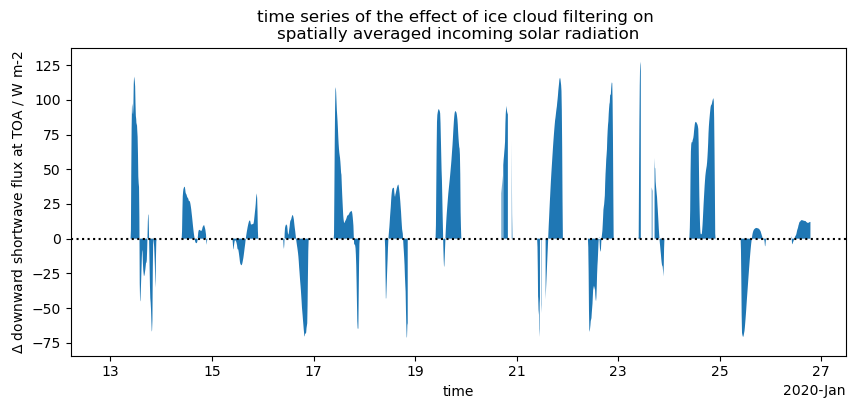

In [5]:
d = pp.filter_by_threshold(data, {'tqi_dia':1e-4}).mean(dim='cell', keep_attrs=True) - data.mean(dim='cell', keep_attrs=True)

fig, ax = plt.subplots()
ax.axhline(0, color='black', ls=':')
d['sod_t'].plot(ax=ax, lw=0)
ax.fill_between(d.time.values, d]['sod_t'].values)
ax.set_ylabel(f'$\Delta$ {data["sod_t"].attrs["long_name"]} / {data["sod_t"].attrs["units"]}')
ax.set_title('time series of the effect of ice cloud filtering on \nspatially averaged incoming solar radiation')
fig.show()

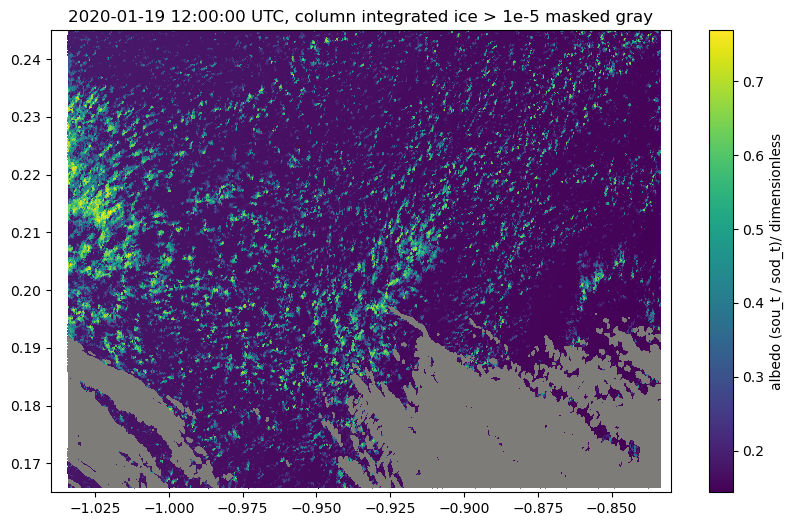

In [13]:
import matplotlib.pyplot as plt
import plot_utils as pu
import pandas as pd

d = load_control_subset(keep_grid_vars=True).isel(time=950)
pp.add_arithmetic_variable(d, 'sou_t', 'sod_t', '/', new_var_name='albedo')
d = pp.add_threshold_indicator(d, 'tqi_dia', 1e-5, 'ice_cloud')
d['ice_cloud'] = d['ice_cloud'].where(d['ice_cloud'] != 0, None)

fig, ax = plt.subplots(figsize=(10,6))
ax = pu.ax_triangles(ax, d, 'albedo')

vertices_of_cells = d['vertex_of_cell'].T.values - 1
z_field = d['ice_cloud'].values
trip = ax.tripcolor(d.vlon, d.vlat, vertices_of_cells, z_field, vmin=0, vmax=2, edgecolor='none', cmap='cividis')

ax.set_xlim(-1.04,-0.83)
ax.set_ylim(0.165,0.245)
ax.set_title(f'{pd.to_datetime(d.time.values)} UTC, column integrated ice > 1e-5 masked gray')
fig.show()

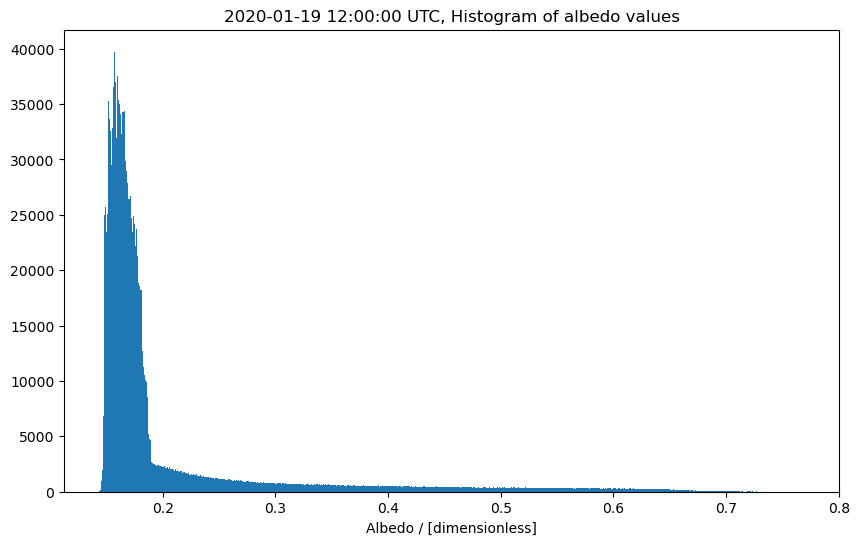

In [14]:
import matplotlib.pyplot as plt
import plot_utils as pu
import pandas as pd

d = load_control_subset(keep_grid_vars=True).isel(time=950)
pp.add_arithmetic_variable(d, 'sou_t', 'sod_t', '/', new_var_name='albedo')
d = pp.add_threshold_indicator(d, 'tqi_dia', 1e-5, 'ice_cloud')
d['ice_cloud'] = d['ice_cloud'].where(d['ice_cloud'] != 0, None)
z_field = d['albedo'].values

fig, ax = plt.subplots(figsize=(10,6))
n, bins, _ = ax.hist(z_field, bins=1000)
ax.set_title(f'{pd.to_datetime(d.time.values)} UTC, Histogram of albedo values')
ax.set_xlabel('Albedo / [dimensionless]')
fig.show()

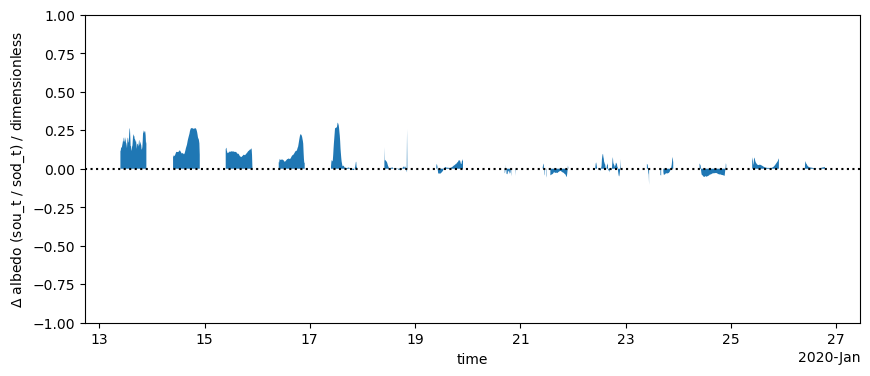

In [19]:
d1 = pp.filter_by_threshold(data, {'tqi_dia':1e-4})
d1 = pp.add_arithmetic_variable(d1, 'sou_t', 'sod_t', '/', new_var_name='albedo')
d2 = pp.add_arithmetic_variable(data, 'sou_t', 'sod_t', '/', new_var_name='albedo')
d = d1.mean(dim='cell', keep_attrs=True) - data.mean(dim='cell', keep_attrs=True)
var = 'albedo'

fig, ax = plt.subplots()
ax.axhline(0, color='black', ls=':')
d$$var$$.plot(ax=ax, lw=0)
ax.fill_between(d.time.values, d$$var$$.values)
ax.set_ylabel(f'$\Delta$ {d1$$var$$.attrs$$"long_name"$$} / {d1$$var$$.attrs$$"units"$$}')
ax.set_ylim(-1,1)
fig.show()

In [3]:
def split_and_mean_by_threshold(dataset, threshold, dim='cell', equal_in_above=True):
    """
    Splits the dataset based on specified thresholds for each variable and computes the mean for each partition.

    Parameters:
    - dataset: The input data array or dataset containing the variables to be split.
    - threshold: A dictionary where key is the variable name and value is the threshold for splitting.
    - dim: The dimension along which to compute the mean. Default is 'cell'.
    - equal_in_above: A boolean indicating whether the threshold is inclusive in the upper partition. Default is True.

    Returns:
    - An xarray object containing the concatenated means of the partitions for each variable.
    """
    if len(threshold) > 1: raise ValueError(f"Processing more than one threshold not implemented.")
    
    mean_datasets = $$$$
    for var, threshold_value in threshold.items():
        if var not in dataset: raise ValueError(f"Variable '{var}' not found in the dataset.")
        if not isinstance(threshold_value, (int, float)): raise ValueError(f"Threshold for '{var}' must be a number.")
        
        if equal_in_above:
            below_indexer = (dataset$$var$$ < threshold_value).compute()
            above_indexer = (dataset$$var$$ >= threshold_value).compute()
        else:
            below_indexer = (dataset$$var$$ <= threshold_value).compute()
            above_indexer = (dataset$$var$$ > threshold_value).compute()

        below_threshold = dataset.where(below_indexer, drop=True)
        above_threshold = dataset.where(above_indexer, drop=True)

        if below_threshold$$var$$.size > 0:
            mean_below = below_threshold.mean(dim=dim, keep_attrs=True)
        else:
            mean_below = xr.full_like(dataset.isel({dim: 0}), fill_value=np.nan)

        if above_threshold$$var$$.size > 0:
            mean_above = above_threshold.mean(dim=dim, keep_attrs=True)
        else:
            mean_above = xr.full_like(dataset.isel({dim: 0}), fill_value=np.nan)

        dimname = f'{var}{">=" if equal_in_above else ">"}{threshold_value}'
        mean_combined = xr.concat($$mean_below, mean_above$$, dim=dimname)
        mean_datasets.append(mean_combined)

    return xr.concat(mean_datasets, dim=dimname)

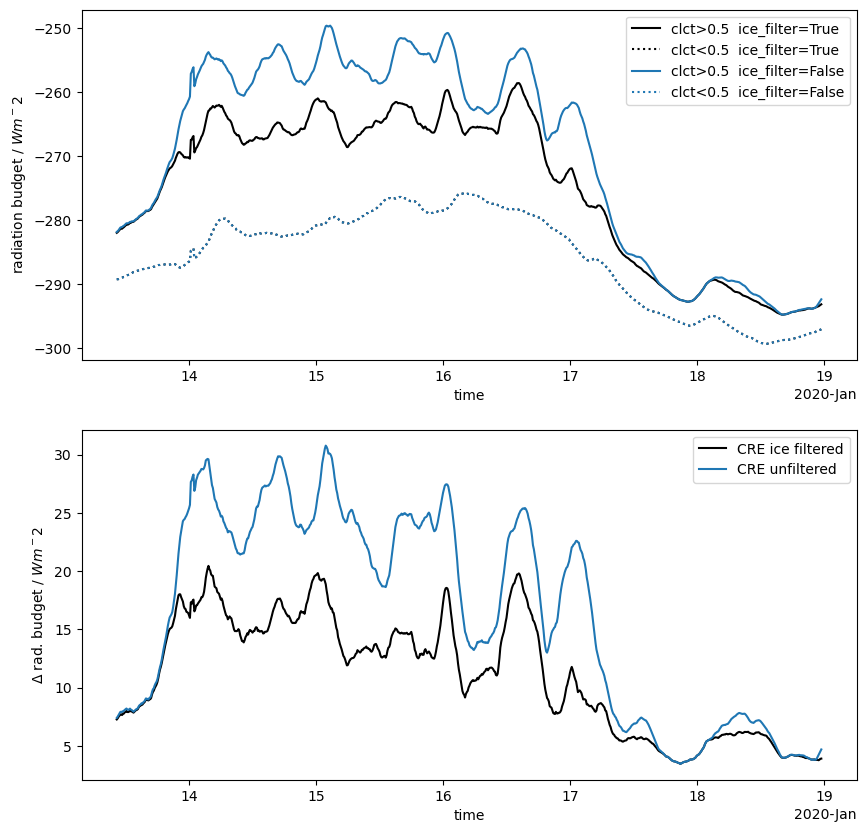

In [24]:
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd


def load_data():
    d = load_control_subset().isel(time=time_slice)
    d = pp.add_arithmetic_variable(d, 'sou_t', 'sod_t', '/', new_var_name='albedo')
    d = pp.add_arithmetic_variable(d, 'sod_t', 'sod_t', '-', new_var_name='SW_budget')
    d = pp.add_arithmetic_variable(d, 'thb_t', 'SW_budget', '+', new_var_name='rad_budget')
    d = pp.add_threshold_indicator(d, 'tqi_dia', 1e-5, 'ice_cloud')
    return d    


def fig_cre_timeseries(time_slice = slice(None, None)):
    fig, axs = plt.subplots(2, 1, figsize=(10,10))
    ax = axs$$0$$
    var = 'rad_budget'
    
    d = load_data() 
    d = pp.filter_by_threshold(d, {'tqi_dia':1e-5}, below_threshold=True)
    d = pp.filter_by_threshold(d, {'clct':50})
    d = d.mean(dim='cell')
    d = d$$var$$
    d.plot(ax=ax, label=f'clct>0.5  ice_filter=True', color='black')
    d2 = d
    
    d = load_data() 
    d = pp.filter_by_threshold(d, {'tqi_dia':1e-5}, below_threshold=True)
    d = pp.filter_by_threshold(d, {'clct':50}, below_threshold=True)
    d = d.mean(dim='cell')
    d = d$$var$$
    d.plot(ax=ax, label=f'clct<0.5  ice_filter=True', color='black', ls=':')
    cre = d2 - d
    cre.plot(ax=axs$$1$$, label='CRE ice filtered', color='black')
    
    d = load_data() 
    d = pp.filter_by_threshold(d, {'clct':50})
    d = d.mean(dim='cell')
    d = d$$var$$
    d.plot(ax=ax, label=f'clct>0.5  ice_filter=False', color='tab:blue')
    d2 = d
    
    d = load_data() 
    d = pp.filter_by_threshold(d, {'clct':50}, below_threshold=True)
    d = d.mean(dim='cell')
    d = d$$var$$
    d.plot(ax=ax, label=f'clct<0.5  ice_filter=False', color='tab:blue', ls=':')
    cre = d2 - d
    cre.plot(ax=axs$$1$$, label='CRE unfiltered', color='tab:blue')
    
    axs$$0$$.set_ylabel(f'radiation budget / $Wm^{-2}$')
    axs$$1$$.set_ylabel(f'$\Delta$ rad. budget / $Wm^{-2}$')
    for ax in axs: ax.legend()
    return fig, axs
    
fig, axs = fig_cre_timeseries()
fig.show()

- normalize signal by altered domain mean incoming shortwave?
- does this kill the unit in feedback?
- does it help to look at averages over coarse gridded data?
- how do satelite based studies deal with ice clouds?

$$
CRE_sw dach = F_as - F_cs = f $$-$$

f = \frac{$$F_{sw}$$_{noise}(t)}{$$F_{sw}$$_{noise}(time mean)}
$$

## How does the Feedback change, if we ice filter?

In [1]:
# avoid dask warnings in the output
import dask
dask.config.set(**{'array.slicing.split_large_chunks': True})

import sys 
import os
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)

import file_handling as fh
import xarray as xr
import postprocessing as pp
import pandas as pd

def load_warming(path=None, time_slice=slice(None, None), keep_grid_vars=False):
    if path == None: path = '/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_05'
    datasets = list()
    # files = fh.disk_data_from_keywords(path, ['surface',   'DOM01'], return_file_list=True[file_slice]
    # datasets.append(xr.open_mfdataset(files))
    datasets.append(fh.disk_data_from_keywords(path, ['surface',   'DOM01']).isel(time=time_slice))
    datasets.append(fh.disk_data_from_keywords(path, ['radiation', 'DOM01']))
    datasets = [pp.clean_surface_data(d) for d in datasets]
    datasets = pp.subset_time_overlap(datasets)
    data = xr.merge(datasets)
    return data

def add_ice_filtered(dataset, threshold=1e-5):
    unfiltered = dataset.expand_dims(ice_filter=(None,))
    dataset = pp.filter_by_threshold(dataset, {'tqi_dia':threshold}, below_threshold=True)
    ice_free = dataset.expand_dims(ice_filter=(f'<{threshold}',))
    dataset = pp.filter_by_threshold(dataset, {'tqi_dia':threshold}, below_threshold=False)
    ice_cloud = dataset.expand_dims(ice_filter=(f'>{threshold}',))
    dataset = xr.concat([unfiltered, ice_free, ice_cloud], dim='ice_filter')
    return dataset

def add_control_to_surface_data(dataset):
    """
    Adds control data to the surface data within the given dataset.

    This function expands the dimensions of the input dataset to include a 'warming' experiment,
    retrieves and merges control datasets for 'surface' and 'radiation' data, ensures both datasets
    contain the same variables, and concatenates them along the 'experiment' dimension.

    Parameters:
    - dataset (xarray.Dataset): The input dataset containing the warming experiment data.

    Returns:
    - xarray.Dataset: The dataset with both warming and control experiments concatenated.
    """
    warming = dataset.expand_dims(experiment=('warming',))
    datasets = list()
    datasets.append(fh.eureca_data_from_keywords(['surface', 'DOM01']))
    datasets.append(fh.eureca_data_from_keywords(['radiation', 'DOM01']))
    datasets = pp.subset_time_overlap(datasets)
    control = xr.merge(datasets)
    common_vars = set(warming.data_vars).intersection(set(control.data_vars))
    warming = warming[common_vars]
    control = control[common_vars]
    control = control.expand_dims(experiment=('control',))
    datasets = pp.subset_time_overlap([warming, control])
    data = xr.concat(datasets, dim='experiment')
    return data


def add_radiation_budget(dataset):
    dataset['sou_t'].values = dataset['sou_t'].values * (-1)
    dataset = pp.add_arithmetic_variable(dataset, 'sou_t', 'sod_t', '/', new_var_name='albedo')
    dataset = pp.add_arithmetic_variable(dataset, 'sou_t', 'sod_t', '+', new_var_name='SW_budget')
    dataset = pp.add_arithmetic_variable(dataset, 'thb_t', 'SW_budget', '+', new_var_name='rad_budget')
    return dataset

fh.disable_warnings()

dataset = load_warming(time_slice=slice(550,700))
dataset = add_control_to_surface_data(dataset)
dataset = add_radiation_budget(dataset)
dataset = pp.local_time(dataset)
dataset = pp.add_threshold_indicator(dataset, {'tqi_dia':1e-5})
dataset = pp.split_along_threshold(dataset, {'clct':50}, 'is_cloud')
dataset = pp.split_along_threshold(dataset, {'tqi_dia':1e-5}, 'is_ice_cloud')
dataset = dataset.mean(dim='cell', keep_attrs=True)
dataset

Any code that generates warnings will no longer print them to the console.


<xarray.Dataset> Size: 130kB
Dimensions:        (is_ice_cloud: 3, is_cloud: 3, experiment: 2, time: 75)
Coordinates:
  * experiment     (experiment) object 16B 'warming' 'control'
  * time           (time) datetime64[ns] 600B 2020-01-11T04:20:00 ... 2020-01...
  * is_cloud       (is_cloud) object 24B None False True
  * is_ice_cloud   (is_ice_cloud) object 24B None False True
Data variables: (12/23)
    tqi_dia        (is_ice_cloud, is_cloud, experiment, time) float32 5kB dask.array<chunksize=(1, 1, 1, 1), meta=np.ndarray>
    v_10m          (is_ice_cloud, is_cloud, experiment, time) float32 5kB dask.array<chunksize=(1, 1, 1, 1), meta=np.ndarray>
    clct           (is_ice_cloud, is_cloud, experiment, time) float32 5kB dask.array<chunksize=(1, 1, 1, 1), meta=np.ndarray>
    sob_t          (is_ice_cloud, is_cloud, experiment, time) float32 5kB dask.array<chunksize=(1, 1, 1, 1), meta=np.ndarray>
    pres_sfc       (is_ice_cloud, is_cloud, experiment, time) float32 5kB dask.array<chunksize=(1, 1, 1, 1), meta=np.ndarray>
    sod_t          (is_ice_cloud, is_cloud, experiment, time) float32 5kB dask.array<chunksize=(1, 1, 1, 1), meta=np.ndarray>
    ...             ...
    rain_gsp_rate  (is_ice_cloud, is_cloud, experiment, time) float32 5kB dask.array<chunksize=(1, 1, 1, 1), meta=np.ndarray>
    lhfl_s         (is_ice_cloud, is_cloud, experiment, time) float32 5kB dask.array<chunksize=(1, 1, 1, 1), meta=np.ndarray>
    albedo         (is_ice_cloud, is_cloud, experiment, time) float32 5kB dask.array<chunksize=(1, 1, 1, 1), meta=np.ndarray>
    SW_budget      (is_ice_cloud, is_cloud, experiment, time) float32 5kB dask.array<chunksize=(1, 1, 1, 1), meta=np.ndarray>
    rad_budget     (is_ice_cloud, is_cloud, experiment, time) float32 5kB dask.array<chunksize=(1, 1, 1, 1), meta=np.ndarray>
    tqi_dia>1e-05  (is_ice_cloud, is_cloud, experiment, time) float64 11kB dask.array<chunksize=(1, 1, 1, 1), meta=np.ndarray>
Attributes:
    CDI:                  Climate Data Interface version 1.8.3rc (http://mpim...
    Conventions:          CF-1.6
    number_of_grid_used:  99
    uuidOfHGrid:          6b59890b-99f3-939b-e76a-0a3ad2e43140
    institution:          Max Planck Institute for Meteorology/Deutscher Wett...
    title:                ICON simulation
    source:               icon\tgit@gitlab.dkrz.de:icon/icon.git@e8171c42bcd2...
    history:              /work/mh1126/m300872/icon_haukestate/bin/icon-e8171...
    references:           see MPIM/DWD publications
    comment:              Hernan Campos (m300872) on l20095 (Linux 4.18.0-425...

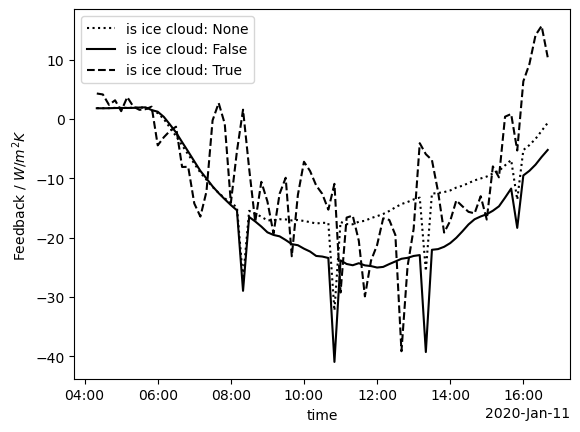

In [2]:
import matplotlib.pyplot as plt

dataset2 = dataset.copy()#.sel(is_ice_cloud=None)
dataset2 = dataset2.sel({'is_cloud':True}) - dataset2.sel({'is_cloud':False})
dataset2 = dataset2.sel({'experiment':'warming'}) - dataset2.sel({'experiment':'control'})

var = 'rad_budget'
fig, ax = plt.subplots()

for ic, ls in zip(dataset2.is_ice_cloud.values, [':','-','--']):
    d = dataset2[var].sel({'is_ice_cloud':ic})
    d.values =  d.values / 4
    d.plot(ax=ax, label=f'is ice cloud: {ic}', ls=ls, color='black')
ax.legend()
ax.set_title(None)
ax.set_ylabel('Feedback / $W/m^2K$')
fig.show()

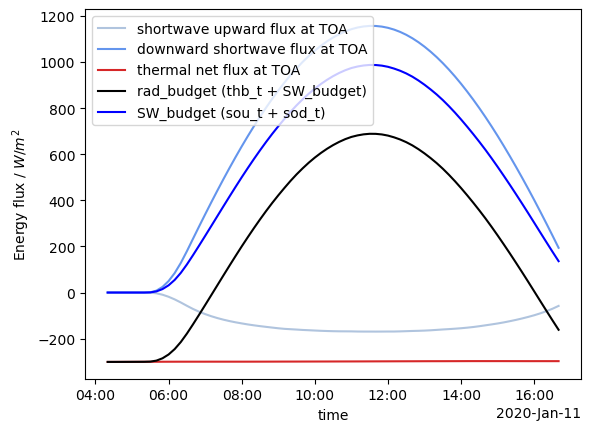

In [3]:
import matplotlib.pyplot as plt

dataset2 = dataset.sel({'experiment':'warming', 'is_cloud':None, 'is_ice_cloud':False})
fig, ax = plt.subplots()

for var, color in zip(['sou_t', 'sod_t', 'thb_t', 'rad_budget', 'SW_budget'], 
                      ['lightsteelblue', 'cornflowerblue', 'tab:red', 'black', 'blue']):
    dataset2[var].plot(ax=ax, label=f'{dataset[var].attrs["long_name"]}', color=color)
ax.legend()
ax.set_title(None)
ax.set_ylabel('Energy flux / $W/m^2$')
fig.show()

## scale up analysis

In [18]:
#!/usr/bin/env python3
#SBATCH --job-name='proc_2'
#SBATCH --account=bm1183
#SBATCH --partition=compute
#SBATCH --array=0-837%15
#SBATCH --time=02:00:00
#SBATCH --mail-type=fail
#SBATCH --mail-user=hernan.campos@mpimet.mpg.de
#SBATCH --output=/scratch/m/m300872/log/%j_%x.log

# avoid dask warnings in the output
import dask
dask.config.set(**{'array.slicing.split_large_chunks': True})

import builtins
def print(*args, **kwargs):
    ''' for printing into SLURM logs'''
    builtins.print(*args, **kwargs, flush=True)
    
import sys 
import os
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)

import file_handling as fh
import xarray as xr
import postprocessing as pp
import pandas as pd

fh.disable_warnings()

def add_control_to_surface_data(dataset):
    """
    Adds control data to the surface data within the given dataset.

    This function expands the dimensions of the input dataset to include a 'warming' experiment,
    retrieves and merges control datasets for 'surface' and 'radiation' data, ensures both datasets
    contain the same variables, and concatenates them along the 'experiment' dimension.

    Parameters:
    - dataset (xarray.Dataset): The input dataset containing the warming experiment data.

    Returns:
    - xarray.Dataset: The dataset with both warming and control experiments concatenated.
    """
    warming = dataset.expand_dims(experiment=('warming',))
    datasets = list()
    datasets.append(fh.eureca_data_from_keywords(['surface', 'DOM01']))
    datasets.append(fh.eureca_data_from_keywords(['radiation', 'DOM01']))
    datasets = pp.subset_time_overlap(datasets)
    control = xr.merge(datasets)
    common_vars = set(warming.data_vars).intersection(set(control.data_vars))
    warming = warming[common_vars]
    control = control[common_vars]
    control = control.expand_dims(experiment=('control',))
    datasets = pp.subset_time_overlap([warming, control])
    data = xr.concat(datasets, dim='experiment')
    return data

def add_radiation_budget(dataset):
    dataset['sou_t'].values = dataset['sou_t'].values * (-1)
    dataset = pp.add_arithmetic_variable(dataset, 'sou_t', 'sod_t', '/', new_var_name='albedo')
    dataset = pp.add_arithmetic_variable(dataset, 'sou_t', 'sod_t', '+', new_var_name='SW_budget')
    dataset = pp.add_arithmetic_variable(dataset, 'thb_t', 'SW_budget', '+', new_var_name='rad_budget')
    return dataset

def load_processed(file_index):
    dataset = load_warming(file_index)
    dataset = add_control_to_surface_data(dataset)
    dataset = add_radiation_budget(dataset)
    dataset = pp.local_time(dataset)
    dataset = pp.add_threshold_indicator(dataset, {'tqi_dia':1e-5})
    dataset = pp.split_along_threshold(dataset, {'clct':50}, 'is_cloud')
    dataset = pp.split_along_threshold(dataset, {'tqi_dia':1e-5}, 'is_ice_cloud')
    dataset = dataset.mean(dim='cell', keep_attrs=True)
    return dataset

def load_warming(file_index=0, path=None, keep_grid_vars=False):
    if path == None: path = '/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_05'
    datasets = list()
    files = fh.disk_data_from_keywords(path, ['surface',   'DOM01'], return_file_list=True)
    datasets.append(xr.open_dataset(files[file_index]))
    datasets.append(fh.disk_data_from_keywords(path, ['radiation', 'DOM01']))
    datasets = [pp.clean_surface_data(d) for d in datasets]
    datasets = pp.subset_time_overlap(datasets)
    data = xr.merge(datasets)
    return data

def process_file(file_index, prefix='processed', output_dir='/scratch/m/m300872/temp', dateformat="%Y%m%dH%H%M"):
    data = load_processed(file_index)
    t0 = pd.to_datetime(data.time.values[0])
    ofile = os.path.join(output_dir, f"{prefix}_{t0.strftime(dateformat)}.nc")
    print(ofile)
    if not os.path.exists(ofile):
        print('\twriting')
        data.to_netcdf(ofile)
    else:
        print('\texists')
    print('\tdone\n')

if fh.is_running_in_notebook():
    print('In notebook. working on file with index 0 as test.')
    process_file(0, prefix='test')
elif __name__ == "__main__":
    task_count = int(os.environ.get("SLURM_ARRAY_TASK_COUNT", 0))
    task_id    = int(os.environ.get("SLURM_ARRAY_TASK_ID", 0))
    file_slice = task_id
    process_file(task_id, prefix='pp3')

Any code that generates warnings will no longer print them to the console.
In notebook. working on file with index 0 as test.
/scratch/m/m300872/temp/test_20200109H0600.nc
	writing
	done



In [20]:
path = '/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_05'
'available files: ', len(fh.disk_data_from_keywords(path, ['surface',   'DOM01'], return_file_list=True))

('available files: ', 837)

## Von Keno

Moin Hernan,
nochmal zu gestern: 

$$
CRE = F_{cs} - F{as} = O_{as} - O_{cs}
$$

wobei $F$ net radiation at TOA and $O$ outgoing (also longwave + shortwave). Jetzt willst du diese Größen von tatsächlichen 'observations' (= Simulationen) schätzen. 

Angenommen deine Simulation würde das clearsky $O$ berechnen, dann wäre der beste Schätzer für das $O_{cs}$ ein space and time average über alle dir zur Verfügung stehenden pixel. 

 $O_{cs} = O_{cs}(I_{sw}, SST)$ => d.h. es gilt 
 
$$
<\bar{O}_{cs}> = \int O_{cs}(I_{sw}, SST) * \rho(I_{sw}, SST) dI_{sw} d SST \simeq \frac{1}{N_i  N_t} \sum_{i=1}^{N_i} \sum_{t=1}^{N_t} O_{cs, i,t}
$$

Du hast aber kein clear-sky $O$ für alle pixel, also musst du dich auf die Pixel beschränken, die clear sky sind. Stattdessen musst du über alle pixel mitteln, die eben clear sky sind 

$$
<\bar{O}_{cs}>  \simeq \frac{1}{\tilde{N}_i  \tilde{N}_t}\sum_{i=1}^{\tilde{N}_i} \sum_{t=1}^{\tilde{N}_t} O_{cs, i,t} 
$$

Du müsstest nun prüfen, ob dein reduziertes sample immer noch eine 'gute' Darstellung von $\rho(I_{sw}, SST)$ ist. Das erreichst du indem du die Verteilung deines nicht reduzierten samples, also alle Beobachtungen im $I_{sw}-SST$-space, mit der Verteilung des reduzierten samples vergleichst. Mach zunächst einfach ein binning für diesen Raum um schau die anomalie der relativen Verteilung an. More advanced wäre dann so was wie eine KDE (Kernel density estimate) aber ich glaube das wäre die Kanone auf Spatzen. Aber wenn das gewährleistet ist, mach einfach die space-time averages und nicht den Funktion-fit Quatsch den ich gestern vorgeschlagen habe. 

Bei $<\bar{O}_{as}>$ wird es ein bisschen kniffliger, weil die 'cloudiness' als dritte dimension dazukommt. Aber hier würde auch versuchen zu zeigen, das ein maskiertes sample ohne ice cloud cells immer noch ein gutes sample ist. 

Bzgl. des time averages: Du meintest an einer Stelle noch, dass du Tagesmittel erstellen würdest, das hab ich noch nicht ganz verstanden. 

Ich hoffe ich hab mich halbwegs verständlich ausgedrückt, wenn nicht, komm nochmal vorbei ;) 

### From talking to Hauke

- $clct$: domain mean cloud fraction
- $CRE$: cloud radiative effect
- $\bar{F_{AS}}$: cloud radiative effect

$$
CRE = \bar{F_{CS}} - \bar{F_{CL}} \cdot clct
$$

$$
CRE = \bar{F_{AS}} - \bar{F_{CL}}
$$

$$
\bar{F_{AS}} = (\bar{F_{CL}} \cdot clct) - (\bar{F_{CS}} \cdot (1 - clct))
$$

$$
CRE = (\bar{F_{CL}} \cdot clct) - (\bar{F_{CS}} \cdot (1 - clct)) - \bar{F_{CL}}
$$

$$
CRE = (F_{CL}  \cdot (clct - 1)) + (F_{CS} \cdot  - (1 - clct)) - \bar{F_{CL}}
$$

$$
CRE = ((F_{CL}  \cdot clct - F_{CL}  \cdot 1)) + ((F_{CS} \cdot -1 + F_{CS} \cdot clct)) - \bar{F_{CL}}
$$

$$
CRE = F_{CL}  \cdot clct - F_{CL} - F_{CS} + F_{CS} \cdot clct - \bar{F_{CL}}
$$

$$
(clclt - 1) (F_{CL} - F_{CS})
$$

$$
clct \cdot F_{CL} - F_{CL} + F_{CS} - F_{CS} \cdot clct
$$

### correction factor

- $frac$: domain mean cloud fraction

$$
F_{total} = F_0 (1 - frac) + F_{ice} (frac)
$$

$$
F_{total} = F_0 (1 - frac + \frac{F_{ice} (frac)}{F_0})
$$

$$
F_{total} = frac * F_0
$$

Korrekturfaktoren 


$$
CRE = \bar{F_{AS}} - \bar{F_{CL}}
$$

$$
\bar{F_{AS}} = (\bar{F_{CL}} \cdot clct) - (\bar{F_{CS}} \cdot (1 - clct))
$$ 

Substitute II into I

$$
CRE = \left((\bar{F_{CL}} \cdot clct) - (\bar{F_{CS}} \cdot (1 - clct))\right) - \bar{F_{CL}}
$$

rearrange parenthesis


$$
CRE = \bar{F_{CL}} \cdot clct - \bar{F_{CL}} - \bar{F_{CS}} \cdot (1 - clct)
$$

$$
CRE = \bar{F_{CL}}(clct - 1) - \bar{F_{CS}} \cdot (1 - clct)
$$


Notice that $(clct - 1) = (-(1 - clct))$

$$
CRE = -\bar{F_{CL}}(1 - clct) - \bar{F_{CS}}(1 - clct)
$$

$$
CRE = -(1 - clct)(\bar{F_{CL}} + \bar{F_{CS}})
$$

$$
CRE = (clct - 1)(\bar{F_{CL}} + \bar{F_{CS}})
$$

$$
CRE = clct \cdot \bar{F_{CL}} - \bar{F_{CL}} + clct \cdot \bar{F_{CS}} - \bar{F_{CS}}
$$